In [103]:
from shutil import copyfile
import os
import numpy as np
from matplotlib import pyplot as plt

#print(os.getcwd())

Loading:  ./1-dataset/userdata-1-sine.csv


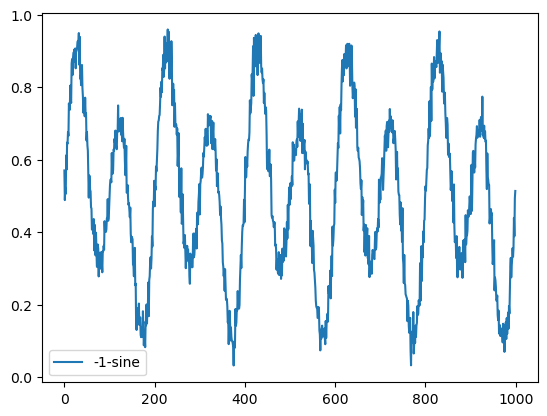

Loading:  ./1-dataset/userdata-2-triangle.csv


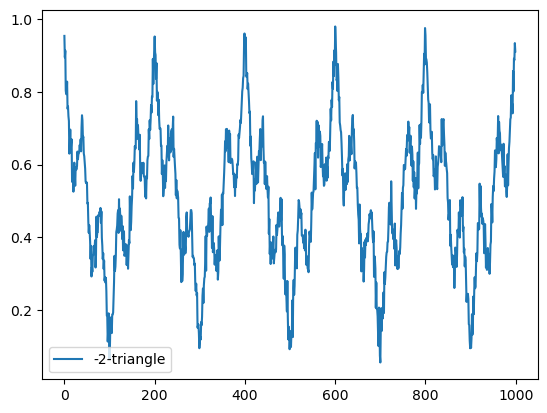

Loading:  ./1-dataset/userdata-3-sawtooth.csv


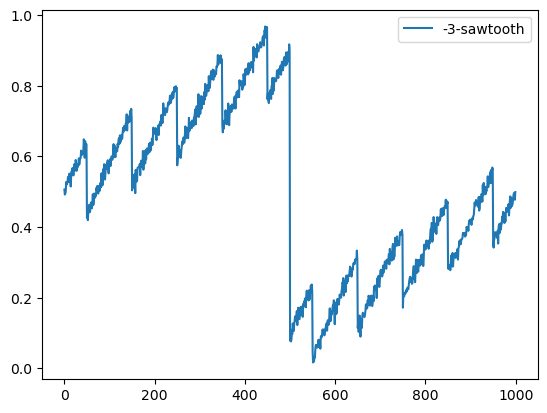

Loading:  ./1-dataset/userdata-4-random.csv


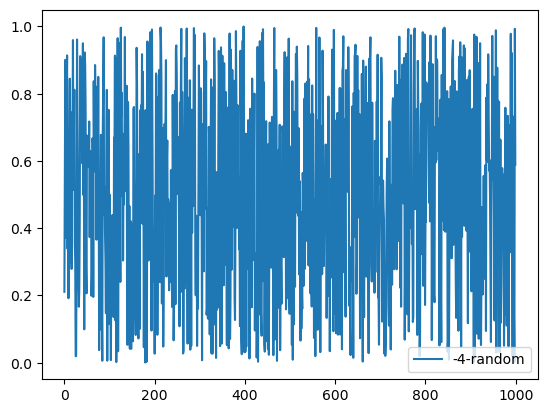

In [104]:
# Loading the dataset
my_delimeter = ","
PLOT_LIM = 1000  # how many data samples to display
datasize = -1  # make sure to use an any "NEGATIVE" value here

dir = "./1-dataset/"
users = ["-1-sine","-2-triangle","-3-sawtooth","-4-random"]

extension = ".csv"
datasets = []
for i in range(len(users)):
    
    src_file = dir + "userdata" + users[i] + extension
    print("Loading: ", src_file)

    dataset = np.loadtxt(src_file, delimiter=my_delimeter)
    datasets.append(dataset)

    #if i == 3: # TEST: plot the first loaded data
    plot_lim = np.min([PLOT_LIM, len(dataset)])
    #print(dataset)
    plt.plot(dataset[:plot_lim], label=users[i])
    plt.legend()
    plt.show()

    if datasize < 0:
        datasize = len(dataset)
    else:
        assert datasize == len(dataset)

#plt.legend()
#plt.show()

In [105]:
# debug
print("number of users datasets: ", len(datasets))
for i in range(len(users)):
    print("User-",i)
    print("\t dataset size: ", datasets[i].shape)
    print("\t", datasets[i][0:10])

number of users datasets:  4
User- 0
	 dataset size:  (50000,)
	 [0.5702 0.4884 0.5232 0.5057 0.6119 0.5728 0.6473 0.644  0.6766 0.6657]
User- 1
	 dataset size:  (50000,)
	 [0.9536 0.8946 0.9132 0.8032 0.7935 0.794  0.8279 0.7534 0.7598 0.7329]
User- 2
	 dataset size:  (50000,)
	 [0.5059 0.4916 0.4949 0.5007 0.5271 0.5203 0.5224 0.5291 0.5417 0.5322]
User- 3
	 dataset size:  (50000,)
	 [0.2108 0.5975 0.9007 0.5958 0.371  0.815  0.914  0.3387 0.5203 0.1917]


In [106]:
# formatting the dataset so that the formatted results can be used for deep learning training
def to_supervisedDataset(data, LookBackWindowSize, ForecastingHorizonSize):
    data_copy = np.array(data)
    #print("size: ", data.shape)
    assert len(data.shape) == 1  # make sure it's an 1D array
    
    n_input = LookBackWindowSize
    n_out = ForecastingHorizonSize

    X, y = [], []
    in_start = 0
    for _ in range(len(data_copy)):
        in_end = in_start + n_input
        out_end = in_end + n_out
        if( out_end < len(data_copy) ):
            x_input = data_copy[in_start:in_end]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data_copy[in_end:out_end])
        in_start += 1
    return np.array(X), np.array(y)


In [107]:
# split the dataset into train and test
def split_dataset(data, split_ratio):
    datalen = len(data)
    last_train_index = round(datalen * split_ratio)
    train = data[:last_train_index]
    test = data[last_train_index:]
    return train, test

In [ ]:
# # check if GPU is available
# import tensorflow as tf 
# from tensorflow.python.client import device_lib

# #print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
# print("Available devices:", tf.config.list_physical_devices())

In [109]:
from tensorflow import keras
from keras import optimizers
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
"""
def build_model(param):
    model = Sequential()
    model.add(Conv1D(filters=param["filter"], 
                     kernel_size=param["kernel_size"], 
                     activation='relu',
                     input_shape=(param["n_lookback_timesteps"],param["n_features"])
                    )
             )
    model.add(MaxPooling1D(pool_size=param["pool_size"]))
    model.add(Flatten())
    model.add(Dense(param["dense_layer1_nodes"], activation=param["layer1_activation"]))
    model.add(Dense(param["dense_layer2_nodes"], activation=param["layer2_activation"]))
    model.add(Dense(param["n_outputs"], activation=param["final_activation"]))
    opt = keras.optimizers.Adam(learning_rate=param["lr"])
    model.compile(optimizer=opt,
                 loss='mse',
                 metrics=[tf.keras.metrics.Accuracy()])
    return model
"""
from tensorflow import keras
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

# LSTM model 
def build_model(param):
    model = Sequential()
    model.add(LSTM(param["lstm_nodes"], 
                   activation=param["lstm_activation"], 
                   input_shape=(param["n_lookback_timesteps"],param["n_features"])))
    model.add(Dense(param["dense_layer1_nodes"], activation=param["layer1_activation"]))
    model.add(Dense(param["dense_layer2_nodes"], activation=param["layer2_activation"]))
    model.add(Dense(param["n_outputs"], activation=param["final_activation"]))
    
    opt = keras.optimizers.Adam(learning_rate=param["lr"])
    model.compile(optimizer=opt,
                 loss='mse',
                 metrics=[tf.keras.metrics.Accuracy()])
    return model

In [110]:
def train_model(Xtrain, ytrain, val, model, param):
    # fit network
    history = model.fit(Xtrain, ytrain, 
              validation_data=val,
              epochs=param["epochs"], 
              batch_size=param["batch_size"], 
              verbose=param["verbose"])
    return model, history

In [111]:
LookBackWindowSize = 128
ForecastingHorizonSize = 5

In [112]:
# create a neural network model
"""
param_build={"filter":16, "kernel_size":8, "pool_size":4, 
             "dense_layer1_nodes":32,
             "dense_layer2_nodes":8,
             "n_lookback_timesteps":LookBackWindowSize, "n_features":1,
             "layer1_activation":"relu",
             "layer2_activation":"relu",
             "final_activation":"linear",
             "n_outputs":ForecastingHorizonSize,
             "lr":0.001}
model1 = build_model(param_build)
model1.summary()
"""
param_build={"lstm_nodes":50, 
             "dense_layer1_nodes":128,
             "dense_layer2_nodes":32,
             "n_lookback_timesteps":LookBackWindowSize, "n_features":1,
             "lstm_activation":"relu",
             "layer1_activation":"relu",
             "layer2_activation":"relu",
             "final_activation":"linear",
             "n_outputs":ForecastingHorizonSize,
             "lr":0.001}

In [113]:
train0, test0 = split_dataset(datasets[1], 0.9)
train0, val0 = split_dataset(train0, 0.9)
print(train0.shape)
print(val0.shape)
print(test0.shape)

Xtrain0, ytrain0 = to_supervisedDataset(train0, LookBackWindowSize, ForecastingHorizonSize)
Xval0, yval0 = to_supervisedDataset(val0, LookBackWindowSize, ForecastingHorizonSize)
Xtest0, ytest0 = to_supervisedDataset(test0, LookBackWindowSize, ForecastingHorizonSize)

print(Xtrain0.shape, ytrain0.shape)
print(Xval0.shape, yval0.shape)
print(Xtest0.shape, ytest0.shape)

(40500,)
(4500,)
(5000,)
(40367, 128, 1) (40367, 5)
(4367, 128, 1) (4367, 5)
(4867, 128, 1) (4867, 5)


In [114]:
with tf.device('/device:GPU:1'):
    model1 = build_model(param_build)
    model1.summary()

    # train the model
    param_train={"verbose":1, "epochs":10, "batch_size":128}
    model1_trained, history1 = train_model(Xtrain0, ytrain0, (Xval0, yval0), model1, param_train)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_15 (Dense)            (None, 128)               6528      
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dense_17 (Dense)            (None, 5)                 165       
                                                                 
Total params: 21221 (82.89 KB)
Trainable params: 21221 (82.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
316/316 [==============================] - 134s 234ms/step - loss: 0.0264 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e

In [115]:
# checking the trained results
history_dict = history1.history
losses=history_dict["loss"]
val_losses=history_dict["val_loss"]
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]


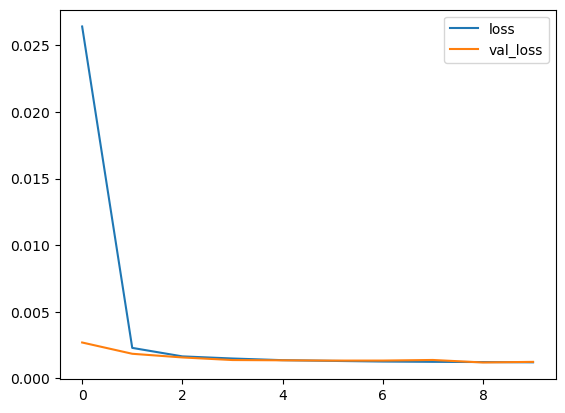

In [116]:
plt.plot(losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.legend()
#plt.ylim((0,20000000000))
#plt.title("Case 1 ; total power")
# plt.show()
plt.savefig('Loss(triangle)(LSTM)[3].pdf')

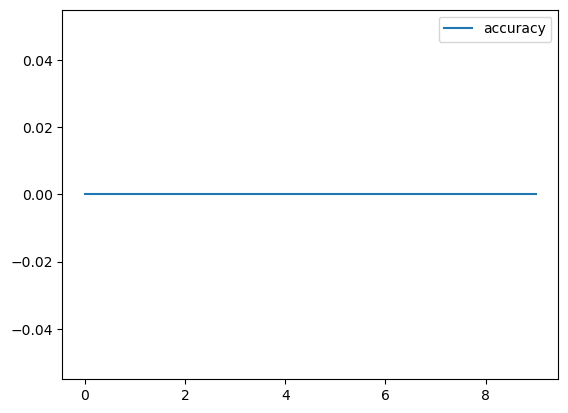

In [117]:
plt.plot(acc, label='accuracy')
plt.legend()
#plt.title("Case 1 ; total power")
# plt.show()
plt.savefig('Accuracy(triangle)(LSTM)[3].pdf')

In [118]:
actual0 = ytest0
pred0 = model1.predict(Xtest0)
assert len(actual0) == len(pred0)
print("RMSE : ", np.sqrt(mean_squared_error(actual0, pred0)))


153/153 [==============================] - 7s 21ms/step
RMSE :  0.03522706333517546


In [119]:
import numpy as np
import pandas as pd

results_df = pd.DataFrame({
    "Actual": ytest0.flatten(),
    "Predicted": pred0.flatten()
})
results_df.to_csv('results_lstm_predictions(triangle)[3].csv', index=False)

history_df = pd.DataFrame(history1.history)
history_df.to_csv('results_lstm_training_history(triangle)[3].csv', index=False)

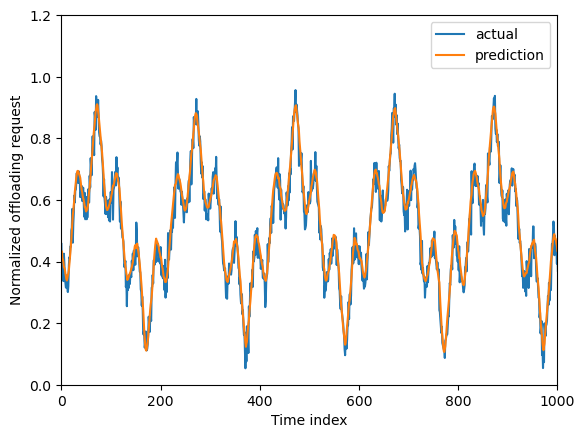

In [120]:
plot_pred = []
plot_actual = []
for i in range(min(len(actual0), len(pred0))):
    plot_pred.append(pred0[i][0]) 
    plot_actual.append(actual0[i][0])
plt.plot(plot_actual, label='actual')
plt.plot(plot_pred, label='prediction')
plt.legend()
plt.xlabel('Time index')
plt.ylabel('Normalized offloading request')
plt.xlim([0,1000])
plt.ylim([0,1.2])
#plt.show()
plt.savefig('Prediction(triangle)(LSTM)[3].pdf')